In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from vit_pytorch import SimpleViT
from fastprogress.fastprogress import master_bar, progress_bar
from torchvision.transforms import RandomResizedCrop, CenterCrop, Resize, RandomHorizontalFlip, Compose, ToTensor
from torch.optim.lr_scheduler import CosineAnnealingLR

/home/dgj335/.local/lib/python3.10/site-packages/beartype/_util/error/utilerrwarn.py:67: BeartypeModuleUnimportableWarning: Ignoring module "onnx" importation exception:
    ImportError: cannot import name 'builder' from 'google.protobuf.internal' (/home/dgj335/.local/lib/python3.10/site-packages/google/protobuf/internal/__init__.py)
  warn(message, cls)
/home/dgj335/.local/lib/python3.10/site-packages/beartype/_util/error/utilerrwarn.py:67: BeartypeModuleUnimportableWarning: Ignoring module "onnx" importation exception:
    ImportError: cannot import name 'builder' from 'google.protobuf.internal' (/home/dgj335/.local/lib/python3.10/site-packages/google/protobuf/internal/__init__.py)
  warn(message, cls)


In [2]:
train_dataset = load_dataset("frgfm/imagenette","full_size",split="train")
valid_dataset = load_dataset("frgfm/imagenette","full_size",split="validation")
rgb_train = train_dataset.filter(lambda s: s["image"].mode == "RGB").with_format("torch")
rgb_valid = valid_dataset.filter(lambda s: s["image"].mode == "RGB").with_format("torch")

In [3]:
def custom_collate_fn(batch):
    train_transforms = Compose(
        [
            RandomResizedCrop(256),
            RandomHorizontalFlip(),
        ]
    )
    images = torch.stack([train_transforms(item['image'].permute(2,0,1).to(torch.float)/255) for item in batch])
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.int64)
    return images, labels

val_transforms = Compose(
    [
        Resize(256,antialias=True),
        CenterCrop(256),
    ]
)

In [4]:
vit = SimpleViT(
    image_size = 256,
    patch_size = 16,
    num_classes = 10,
    dim = 384,
    depth = 12,
    heads = 6,
    mlp_dim = 1536
).cuda()

In [5]:
epochs = 90
batch_size = 64
accumulation_steps = 64//batch_size

loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
# scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

train_loss = []
test_loss = []
val_accuracy = []

Epoch: 1, Accuracy: 0.2235


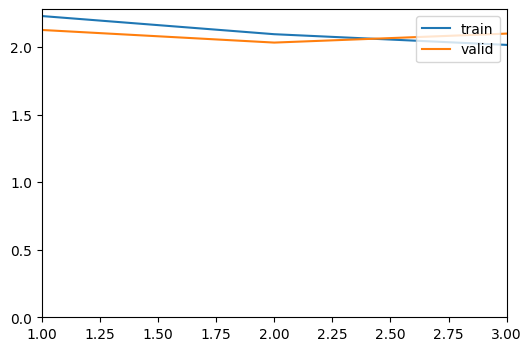

/home/dgj335/.local/lib/python3.10/site-packages/fastprogress/fastprogress.py:206: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  if x_bounds is not None: self.graph_ax.set_xlim(*x_bounds)


Epoch: 2, Accuracy: 0.2809
Epoch: 3, Accuracy: 0.2386


In [ ]:
mb = master_bar(range(1, epochs + 1))

for epoch in mb:
    
    dataloader_train = DataLoader(rgb_train, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=12, collate_fn=custom_collate_fn)
    dataloader_valid = DataLoader(rgb_valid, batch_size=1, shuffle=False, drop_last=False)

    # Training
    vit.train()
    optimizer.zero_grad()
    running_loss = 0.0
    for i_batch, (x, target) in enumerate(progress_bar(dataloader_train, parent=mb)):
        x = x.cuda()
        outputs = vit(x)
        loss = loss_function(outputs, target.cuda())
        loss.backward()
        print(loss.item(), end='\r')
        running_loss += loss.item()

        if (i_batch + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    train_epoch_loss = running_loss / len(dataloader_train)
    train_loss.append(train_epoch_loss)
    
    # Validation
    vit.eval()
    running_loss_val = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for inputs in dataloader_valid:
            x = inputs['image'].permute(0,3,1,2).to(torch.float)/255
            x = val_transforms(x).cuda()
            targets = inputs['label'].to(torch.int64).cuda()
            outputs = vit(x)
            loss = loss_function(outputs, targets)
            running_loss_val += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets).sum().item()
            total_predictions += targets.size(0)
    val_epoch_loss = running_loss_val / len(dataloader_valid)
    test_loss.append(val_epoch_loss)
    epoch_accuracy = correct_predictions / total_predictions
    print(f'Epoch: {epoch}, Accuracy: {epoch_accuracy:.4f}')
    val_accuracy.append(epoch_accuracy)
    graphs = [
        [range(1, epoch + 1), train_loss],  # Training Loss
        [range(1, epoch + 1), test_loss],  # Validation Loss
    ]
    x_bounds = [1, epoch]
    y_bounds = [min(min(train_loss + test_loss) - 0.05, 0), max(max(train_loss + test_loss) + 0.05, 1)]
    mb.update_graph(graphs, x_bounds, y_bounds)
    checkpoint_filename = f'simplevit_imagenette_e{epoch}.pt'
    checkpoint = {
        'model_state_dict': vit.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        # 'scheduler_state_dict': scheduler.state_dict(),
        'epoch': epoch,
        'train_loss': train_loss,
        'test_loss': test_loss,
        'val_accuracy': val_accuracy
    }
    torch.save(checkpoint, checkpoint_filename)
    # scheduler.step()